# L'engagement des rappeurs 

Nous allons essayer de voir si les rappeurs sont engagés, dans quels thèmes, puis nous allons les comparer. 

## Le Corpus

Commençons d'abord par ouvrir les fichiers et par trier les musiques dans un DataFrame panda. 

On importe les packages

In [159]:
# packages
from tqdm import tqdm
import spacy
from scipy.spatial import distance
from spacy import displacy
from sklearn.cluster import KMeans
nlp = spacy.load("fr_core_news_lg")
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import re
import numpy as np 
import pandas as pd 

Puis on créé notre table de données

In [67]:
lyrics = pd.DataFrame({"auteur":[], "pageviews":[], "date":[], "lyric":[]})

On peut regarder notre table à tout moment

In [68]:
lyrics

,auteur,pageviews,date,lyric


Convertissons maintenat les fichiers lyrics en entrée dans cette table

In [75]:
lyrics = pd.DataFrame({"auteur":[], "pageviews":[], "date":[], "lyric":[]})
for file in os.listdir("./lyrics"):
    if file.endswith("_lyrics.txt"):
        t = open("./lyrics/" + file, "r", encoding="utf8").read()
        auteur = file.split("_lyrics.txt")[0]
        t = re.sub("\\[.*\\]", "", t)
        t = re.sub("You might also like", "", t)
        songs = t.split("Date : ")
        songs.pop(0)
        for song in songs:
            lines = song.split("\n")
            date = lines.pop(0)
            pageviews = lines.pop(0).split("PageViews : ")[1]
            lines.pop(0)
            lyric = ".".join(filter(lambda x: x!= "", lines))
            lyrics.loc[len(lyrics)] = [auteur, pageviews, date, lyric]

In [76]:
lyrics

,auteur,pageviews,date,lyric
0,Alkpote,160486,2017-12-04,"Pute, pute, pute, pute, pute, pute, pute, pute..."
1,Alkpote,106429,2019-01-25,"DJ Weedim on the stove.Pu-pu-pu-pute, pu-pu-pu..."
2,Alkpote,53086,2019-07-08,"Tounsi, ris-Kaa.Octo-pute, aqua-pute, cara-put..."
3,Alkpote,48636,2016-06-27,"Le grand aigle, épisode 2, les marches de l'em..."
4,Alkpote,37814,2015-03-23,"Mon poussin, j'en roule un, j'me prends pour J..."
...,...,...,...,...
4043,Zoxea,0,1999-01-01,"Ouais mec faut tout donner.Zoxea, avec un titr..."
4044,Zoxea,0,1997-01-01,"Ouais, ouais, zilizoxea, Sages Po, t'as vu ?.B..."
4045,Zoxea,0,None,100% exclusif.(définition d'un monde).Zoxea.16...
4046,Zoxea,0,2007-03-05,"Eh, il est très rare que je me trompe musicale..."


In [26]:
lyrics.dtypes

auteur       object
pageviews    object
date         object
lyric        object
dtype: object

On remarque que la date est stockée comme un object, donc comme une chaine de caractères, et non comme une date.

In [79]:
lyrics["date"] = pd.to_datetime(lyrics["date"], format = "%Y-%m-%d", errors='coerce')

In [80]:
lyrics

,auteur,pageviews,date,lyric
0,Alkpote,160486,2017-12-04,"Pute, pute, pute, pute, pute, pute, pute, pute..."
1,Alkpote,106429,2019-01-25,"DJ Weedim on the stove.Pu-pu-pu-pute, pu-pu-pu..."
2,Alkpote,53086,2019-07-08,"Tounsi, ris-Kaa.Octo-pute, aqua-pute, cara-put..."
3,Alkpote,48636,2016-06-27,"Le grand aigle, épisode 2, les marches de l'em..."
4,Alkpote,37814,2015-03-23,"Mon poussin, j'en roule un, j'me prends pour J..."
...,...,...,...,...
4043,Zoxea,0,1999-01-01,"Ouais mec faut tout donner.Zoxea, avec un titr..."
4044,Zoxea,0,1997-01-01,"Ouais, ouais, zilizoxea, Sages Po, t'as vu ?.B..."
4045,Zoxea,0,NaT,100% exclusif.(définition d'un monde).Zoxea.16...
4046,Zoxea,0,2007-03-05,"Eh, il est très rare que je me trompe musicale..."


In [30]:
lyrics.dtypes

auteur               object
pageviews            object
date         datetime64[ns]
lyric                object
dtype: object

Comme première étude du corpus, on peut par exemple regarder l'évolution du nombre de musique de rap avec le temps.

In [33]:
music_year = lyrics.groupby(lyrics.date.dt.year)['date'].count()

In [34]:
music_year

date
1987.0      1
1990.0      5
1991.0     10
1992.0      8
1993.0      7
1994.0     21
1995.0     55
1996.0     21
1997.0     62
1998.0    100
1999.0     81
2000.0     77
2001.0     87
2002.0     62
2003.0     66
2004.0     45
2005.0     95
2006.0    123
2007.0     93
2008.0     85
2009.0     82
2010.0    121
2011.0    101
2012.0    162
2013.0    181
2014.0    107
2015.0    251
2016.0    261
2017.0    287
2018.0    201
2019.0    220
2020.0    165
2021.0     88
2022.0     35
Name: date, dtype: int64

<Axes: xlabel='date'>

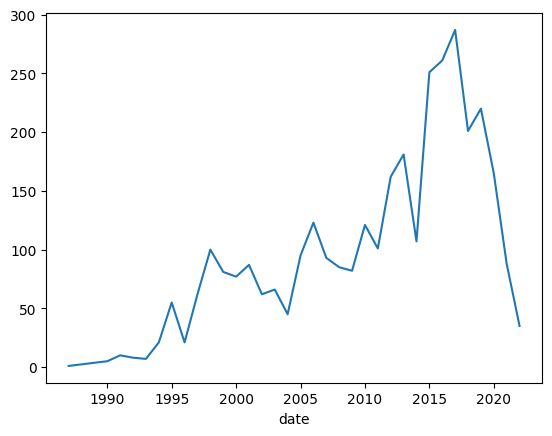

In [53]:
music_year.plot()

## Word embeddings

Dans une première tentative de repérer les musiques engagées, nous allons vectoriser les mots, puis les musiques, et les comparer aux vecteurs associés aux thèmes, tels que "politique" ou "écologie". 

Notons avant tout que nous ne voulons pas analyser tous les mots: notons donc les mots que nous ne souhaitons pas

In [99]:
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']

### NTM

Le corpus étant assez grand, réduisons d'abord le corpus aux musiques de NTM, et analysons les grâce au modèle préentrainé de SpaCy. 

On filtre d'abord le DataFrame pour garder que les musiques de NTM.

In [192]:
ntm = lyrics[lyrics.auteur == "NTM"]

In [193]:
ntm

,auteur,pageviews,date,lyric
2812,NTM,102462,1998-04-21,"À l'aube de l'an 2000, pour les jeunes, c'est ..."
2813,NTM,94574,1998-04-21,"Yo, yo rude boy !.Jaguar Gorgone, Kool Shen, L..."
2814,NTM,72932,1998-04-21,"J't'explique, c'que j'kiffe, c'est de fumer de..."
2815,NTM,57513,2018-09-14,"Hé hé, Fianso, le 9 et le 3 sur le drapeau.Hé ..."
2816,NTM,52125,1998-04-21,"C'est le nouveau, phénoménal, freestyle du vis..."
2817,NTM,45777,1998-04-21,Boom boom bang bad boy pose ton gun.Boom boom ...
2818,NTM,33299,1993-03-15,Eh patron ?.- Oui mon p'tit Pujol ?.- Ils vien...
2819,NTM,31826,1996-12-30,"Yeah, Affirmative Action, with my crew, NTM.Th..."
2820,NTM,27297,1995-03-27,Tout a débuté un matin quand à dix heures dix....
2821,NTM,25632,1995-02-13,"Tout n'est pas si facile, tout ne tient qu'à u..."


Essayons d'abord de tokenizer une musique

In [136]:
doc = nlp(ntm.values[0][3])

In [147]:
doc

À l'aube de l'an 2000, pour les jeunes, c'est plus le même deal.Pour celui qui traîne, comme pour celui qui file tout droit.De toute façon, y a plus de boulot, la boucle est bouclée, le système a la tête sous l'eau.Et les jeunes sont saoulés, salis sous le silence, seule issue la rue même quand elle est en sang.C'est pas un souci pour ceux qui s'y sont préparés et si ça se peut, certains d'entre eux même s'en sortiront mieux.Mais pour les autres, c'est clair, ça sera pas facile, faut pas s'voiler la face, il suffit pas d'vendre des kil'.Faut tenir l'terrain, pour l'lendemain, s'assurer qu'les siens aillent bien, éviter les coups d'surin.Afin d'garder son bien intact, son équipe compacte, soudée, écoute de scanner pour garder l'contact.Ou décider d'bouger, éviter les zones rouges et surtout, jamais prendre de congés.C'est ça qu'tu veux pour ton fils ? C'est comme ça qu'tu veux qu'il grandisse ?.J'ai pas d'conseil à donner mais si tu veux pas qu'il glisse.Regarde-le, quand il parle, écou

In [139]:
doc.vector

array([ 5.45146942e-01, -1.32385397e+00, -2.53256559e+00,  9.19515431e-01,
        6.63935319e-02,  1.64465737e+00, -6.18941426e-01,  9.07789230e-01,
       -3.23970139e-01,  4.06981170e-01,  2.27621764e-01,  4.23632443e-01,
        2.49124527e-01, -7.09162235e-01,  7.77900815e-01, -9.90882933e-01,
        3.74993756e-02,  8.37840810e-02,  9.78314936e-01, -6.24337018e-01,
       -3.09858024e-01,  1.62635613e-02, -8.19023177e-02,  5.27541712e-02,
       -2.31723651e-01,  1.47171974e-01,  1.19465865e-01,  7.60166764e-01,
       -4.31175590e-01,  1.11096323e+00,  6.72676206e-01, -2.05609009e-01,
       -5.60459137e-01, -1.77995944e+00,  1.09684527e+00,  1.43901035e-01,
        1.35048658e-01,  1.87413216e+00, -2.45777816e-01, -1.55199659e+00,
        1.61374819e+00, -1.13528585e+00, -1.02480197e+00,  5.21971047e-01,
       -3.03845525e-01,  2.06349894e-01,  2.86148131e-01, -8.07335079e-01,
       -1.10941553e+00, -8.32667872e-02,  3.37302119e-01, -9.44051266e-01,
       -5.59755445e-01, -

In [153]:
sentence_spans = list(doc.sents)
displacy.serve(sentence_spans, style="dep")


Using the 'dep' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


On voit donc que l'on peut facilement vectoriser une musique. Rajoutons une colonne au DataFrame et faisons ça pour chaque musiques.

In [194]:
ntm.insert(4, "vector", [nlp(lyric).vector for lyric in ntm["lyric"]])

In [146]:
ntm

,auteur,pageviews,date,lyric,vector
2812,NTM,102462,1998-04-21,"À l'aube de l'an 2000, pour les jeunes, c'est ...","[0.54514694, -1.323854, -2.5325656, 0.91951543..."
2813,NTM,94574,1998-04-21,"Yo, yo rude boy !.Jaguar Gorgone, Kool Shen, L...","[0.34203166, -0.9803136, -2.3952732, 0.1503160..."
2814,NTM,72932,1998-04-21,"J't'explique, c'que j'kiffe, c'est de fumer de...","[0.27094674, -0.6130367, -1.848353, 0.74390626..."
2815,NTM,57513,2018-09-14,"Hé hé, Fianso, le 9 et le 3 sur le drapeau.Hé ...","[0.16305593, -0.73461264, -1.2320448, 1.333492..."
2816,NTM,52125,1998-04-21,"C'est le nouveau, phénoménal, freestyle du vis...","[0.13694714, -0.54102093, -1.821335, 0.6418377..."
2817,NTM,45777,1998-04-21,Boom boom bang bad boy pose ton gun.Boom boom ...,"[0.066576324, -0.82356554, -1.9044793, 0.97469..."
2818,NTM,33299,1993-03-15,Eh patron ?.- Oui mon p'tit Pujol ?.- Ils vien...,"[0.30016348, -0.82659686, -1.1808612, 1.036649..."
2819,NTM,31826,1996-12-30,"Yeah, Affirmative Action, with my crew, NTM.Th...","[0.10257802, 0.34147948, -0.89204335, 0.215535..."
2820,NTM,27297,1995-03-27,Tout a débuté un matin quand à dix heures dix....,"[0.46318504, -0.6414312, -1.7456207, 0.7787880..."
2821,NTM,25632,1995-02-13,"Tout n'est pas si facile, tout ne tient qu'à u...","[0.19131528, -0.9376549, -2.2608724, 1.4345722..."


On cherche maintenant à comparer chacun de ces vecteurs avec les vecteurs de mots thématiques

In [154]:
politique_vector = nlp("politique").vector

In [155]:
politique_vector

array([-2.6100e-02, -1.1367e-01, -7.3501e-01,  3.7982e+00, -2.8684e+00,
        1.3146e+00,  6.9198e-01,  2.5899e+00, -3.6980e-01, -2.4562e+00,
       -2.5191e+00,  2.5042e+00, -9.8075e-01, -4.2458e+00, -1.1864e+00,
       -9.9314e-01,  1.0240e+00, -6.5150e-01,  1.5063e+00,  4.5079e+00,
        1.9839e+00,  5.7551e-01,  6.9445e-01, -1.7889e+00, -2.3826e+00,
        1.0660e+00,  9.7584e-01, -2.2553e+00,  1.4054e+00, -1.7875e-01,
        1.2326e-01,  1.0044e+00,  9.2738e-01,  1.4515e+00,  1.5911e+00,
        1.9256e+00,  2.4483e+00, -1.4690e+00,  2.3743e+00,  3.6693e-01,
        2.6453e+00,  1.8599e+00, -9.1631e-02,  1.7932e-01, -1.1706e-01,
       -1.1687e+00, -6.0254e-01, -2.8744e+00, -2.9752e+00,  4.9386e-01,
       -3.8346e+00, -3.5194e-02, -1.6021e+00,  1.7690e+00,  2.4500e-01,
        1.0756e+00,  7.1838e-01, -1.5311e+00, -9.3738e-01,  4.1010e-01,
       -6.4610e-02, -1.8755e+00, -1.0575e+00, -3.0280e-02,  1.7359e+00,
       -3.4418e-01,  1.1512e-01, -2.7267e+00, -1.2631e+00, -4.02

In [190]:
ecologie_vector = nlp("écologie").vector
lutte_vector = nlp("lutte").vector

A titre d'exemple, on peut comparer le vecteur écologie avec celui de la première musique

In [160]:
distance.cosine(ecologie_vector, doc.vector)

0.8695350140333176

In [195]:
ntm.insert(5, "distance_politique", [distance.cosine(politique_vector, vector) for vector in ntm["vector"]])
ntm.insert(5, "distance_ecologie", [distance.cosine(ecologie_vector, vector) for vector in ntm["vector"]])
ntm.insert(5, "distance_lutte", [distance.cosine(lutte_vector, vector) for vector in ntm["vector"]])

In [196]:
ntm

,auteur,pageviews,date,lyric,vector,distance_lutte,distance_ecologie,distance_politique
2812,NTM,102462,1998-04-21,"À l'aube de l'an 2000, pour les jeunes, c'est ...","[0.54514694, -1.323854, -2.5325656, 0.91951543...",0.843232,0.869535,0.748003
2813,NTM,94574,1998-04-21,"Yo, yo rude boy !.Jaguar Gorgone, Kool Shen, L...","[0.34203166, -0.9803136, -2.3952732, 0.1503160...",0.991013,0.980127,0.986512
2814,NTM,72932,1998-04-21,"J't'explique, c'que j'kiffe, c'est de fumer de...","[0.27094674, -0.6130367, -1.848353, 0.74390626...",0.852024,0.855259,0.794968
2815,NTM,57513,2018-09-14,"Hé hé, Fianso, le 9 et le 3 sur le drapeau.Hé ...","[0.16305593, -0.73461264, -1.2320448, 1.333492...",0.745489,0.743773,0.664134
2816,NTM,52125,1998-04-21,"C'est le nouveau, phénoménal, freestyle du vis...","[0.13694714, -0.54102093, -1.821335, 0.6418377...",0.872360,0.863825,0.827594
2817,NTM,45777,1998-04-21,Boom boom bang bad boy pose ton gun.Boom boom ...,"[0.066576324, -0.82356554, -1.9044793, 0.97469...",0.856962,0.883422,0.792929
2818,NTM,33299,1993-03-15,Eh patron ?.- Oui mon p'tit Pujol ?.- Ils vien...,"[0.30016348, -0.82659686, -1.1808612, 1.036649...",0.694873,0.720854,0.570094
2819,NTM,31826,1996-12-30,"Yeah, Affirmative Action, with my crew, NTM.Th...","[0.10257802, 0.34147948, -0.89204335, 0.215535...",0.922347,0.944285,0.873864
2820,NTM,27297,1995-03-27,Tout a débuté un matin quand à dix heures dix....,"[0.46318504, -0.6414312, -1.7456207, 0.7787880...",0.842775,0.867296,0.784084
2821,NTM,25632,1995-02-13,"Tout n'est pas si facile, tout ne tient qu'à u...","[0.19131528, -0.9376549, -2.2608724, 1.4345722...",0.802994,0.821343,0.670137


In [163]:
ntm["distance_ecologie"].describe()

count    50.000000
mean      0.814131
std       0.064241
min       0.720854
25%       0.768085
50%       0.804782
75%       0.852849
max       0.983233
Name: distance_ecologie, dtype: float64

In [164]:
ntm["distance_politique"].describe()

count    50.000000
mean      0.713737
std       0.099047
min       0.557805
25%       0.646935
50%       0.702841
75%       0.754645
max       1.001400
Name: distance_politique, dtype: float64

In [197]:
ntm["distance_lutte"].describe()

count    50.000000
mean      0.801086
std       0.070036
min       0.693874
25%       0.746359
50%       0.800971
75%       0.841384
max       0.992511
Name: distance_lutte, dtype: float64

On remarque ainsi que NTM est plus engagé politiquement que écologiquement, bien que ce le soit peu dans les deux cas.

### Etude de quelques autres auteurs

Maintenant que nous avons vu comment étudier un auteur, généralisons le procédé.

In [198]:
def etude(auteur):
    df = lyrics[lyrics.auteur == auteur]
    df.insert(4, "vector", [nlp(lyric).vector for lyric in df["lyric"]])
    df.insert(5, "distance_politique", [distance.cosine(politique_vector, vector) for vector in df["vector"]])
    df.insert(5, "distance_ecologie", [distance.cosine(ecologie_vector, vector) for vector in df["vector"]])
    df.insert(5, "distance_lutte", [distance.cosine(lutte_vector, vector) for vector in df["vector"]])
    return {"ecologie":df["distance_ecologie"].describe(), "politique":df["distance_politique"].describe(), "lutte":df["distance_lutte"].describe()}

In [ ]:
Voici le résultat appliqué à Orelsan

In [200]:
orelsan = etude("Orelsan")
orelsan

{'ecologie': count    50.000000
 mean      0.865017
 std       0.058859
 min       0.735890
 25%       0.840130
 50%       0.868343
 75%       0.899807
 max       0.996012
 Name: distance_ecologie, dtype: float64,
 'politique': count    50.000000
 mean      0.800297
 std       0.093609
 min       0.568931
 25%       0.754396
 50%       0.793467
 75%       0.861060
 max       0.986130
 Name: distance_politique, dtype: float64,
 'lutte': count    50.000000
 mean      0.853464
 std       0.062167
 min       0.709773
 25%       0.827809
 50%       0.850997
 75%       0.891593
 max       0.980366
 Name: distance_lutte, dtype: float64}

On remarque que la moyenne correspond généralement à la médiane, ce qui montre que l'artiste est assez homogène, sauf pour son côté politique ou la moyenne est notablement plus basse que la médiane: cela signifie que l'artiste a fait moins de musiques engagées politiquement, mais elles sont bien plus engagées.
Cela s'explique en connaissant Orelsan, et en sachant qu'il a commencé que récemment à faire des musiques plus engagées. 

Essayons maintenant d'appliquer le même processus à d'autres auteurs, et de comparer leurs résulats

In [221]:
stats = pd.DataFrame({"auteur":[], "ecologie":[], "politique":[], "lutte":[]})
def ajouter_stats(auteur):
    temp = etude(auteur)
    stats.loc[len(stats)] = [auteur, temp["ecologie"]["50%"],  temp["politique"]["50%"],  temp["lutte"]["50%"]]
ajouter_stats("BigfloOli")
ajouter_stats("Alkpote")
ajouter_stats("Booba")
ajouter_stats("NTM")
ajouter_stats("Orelsan")

In [222]:
stats

,auteur,ecologie,politique,lutte
0,BigfloOli,0.860819,0.797966,0.857453
1,Alkpote,0.865651,0.820990,0.861486
2,Booba,0.874677,0.811268,0.852096
3,NTM,0.804782,0.702841,0.800971
4,Orelsan,0.868343,0.793467,0.850997


On refond le tableau et on l'arrange pour nos comparaisons

In [277]:
plotstats = stats.melt(id_vars="auteur", value_vars=["ecologie", "politique", "lutte"], var_name="category")
plotstats['value'] = 1 - plotstats['value']
plotstats

,auteur,category,value
0,BigfloOli,ecologie,0.139181
1,Alkpote,ecologie,0.134349
2,Booba,ecologie,0.125323
3,NTM,ecologie,0.195218
4,Orelsan,ecologie,0.131657
5,BigfloOli,politique,0.202034
6,Alkpote,politique,0.179010
7,Booba,politique,0.188732
8,NTM,politique,0.297159
9,Orelsan,politique,0.206533


On peut maintenant comparer le côté politique de chaque auteur

<Axes: xlabel='auteur'>

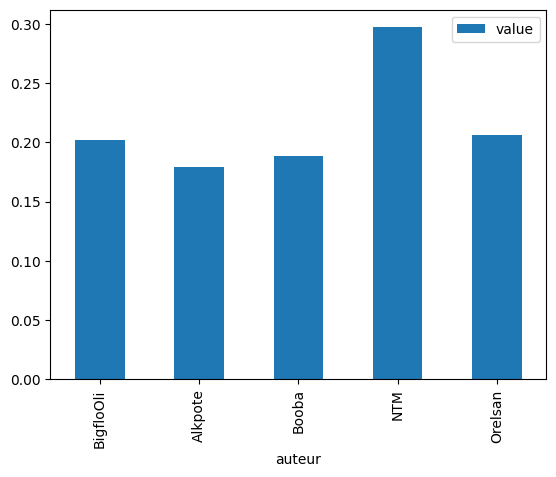

In [278]:
plotstats[plotstats.category == "politique"].plot.bar(x="auteur", y="value")

Ou de même, le côté écologique

<Axes: xlabel='auteur'>

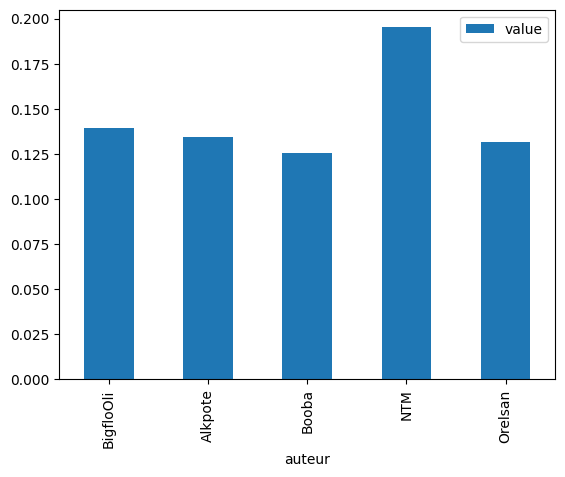

In [279]:
plotstats[plotstats.category == "ecologie"].plot.bar(x="auteur", y="value")

De même, on peut comparer les différents aspect d'un même auteur

<Axes: xlabel='category'>

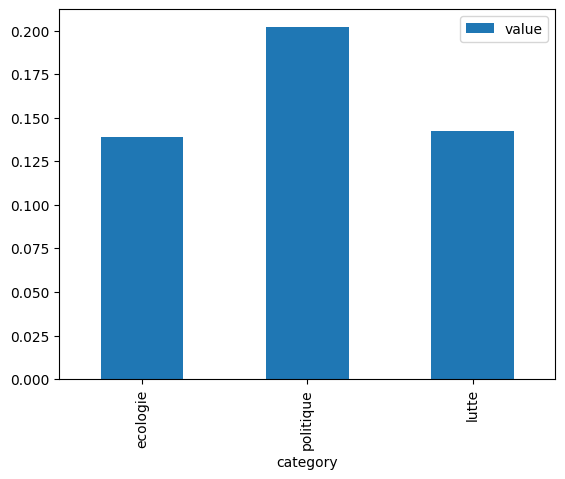

In [281]:
plotstats[plotstats.auteur == "BigfloOli"].plot.bar(x="category", y="value")

## Une autre approche : K-means

On peut aussi essayer de regarder l'engagement d'un auteur en catégorisant ses musiques et en regardant quelles catégories sont engagées.

Pour ce faire, nous allons utiliser scikit-learn

Créons d'abord un modèle

In [335]:
kmeans_model = KMeans(n_clusters=5, random_state=0, n_init="auto")

### NTM

Pour commencer, entrainons le modèle sur les musiques de NTM. On doit pour ça d'abord récuperer le vecteur de chaque musique. 

In [336]:
vectors = [x[4] for x in ntm.values]
vectors

[array([ 5.45146942e-01, -1.32385397e+00, -2.53256559e+00,  9.19515431e-01,
         6.63935319e-02,  1.64465737e+00, -6.18941426e-01,  9.07789230e-01,
        -3.23970139e-01,  4.06981170e-01,  2.27621764e-01,  4.23632443e-01,
         2.49124527e-01, -7.09162235e-01,  7.77900815e-01, -9.90882933e-01,
         3.74993756e-02,  8.37840810e-02,  9.78314936e-01, -6.24337018e-01,
        -3.09858024e-01,  1.62635613e-02, -8.19023177e-02,  5.27541712e-02,
        -2.31723651e-01,  1.47171974e-01,  1.19465865e-01,  7.60166764e-01,
        -4.31175590e-01,  1.11096323e+00,  6.72676206e-01, -2.05609009e-01,
        -5.60459137e-01, -1.77995944e+00,  1.09684527e+00,  1.43901035e-01,
         1.35048658e-01,  1.87413216e+00, -2.45777816e-01, -1.55199659e+00,
         1.61374819e+00, -1.13528585e+00, -1.02480197e+00,  5.21971047e-01,
        -3.03845525e-01,  2.06349894e-01,  2.86148131e-01, -8.07335079e-01,
        -1.10941553e+00, -8.32667872e-02,  3.37302119e-01, -9.44051266e-01,
        -5.5

Puis on entraine le modèle

In [337]:
kmeans = kmeans_model.fit(vectors)
kmeans.labels_

C:\Users\ninja\anaconda3\envs\rap\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([3, 2, 2, 3, 2, 4, 1, 4, 2, 3, 3, 3, 3, 3, 1, 1, 4, 3, 1, 3, 3, 1,
       3, 1, 1, 1, 4, 2, 3, 2, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 3, 4, 1, 1,
       0, 4, 2, 1, 1, 4])

Les labels étant comme ça impossibles à visualiser, nous allons essayer de voir les mots les plus fréquents dans chaque cluster, pour essayer de comprendre le sens de chaque cluster

In [338]:
mots_importants = []
for i in range(5):
    mots = {}
    for j in range(len(vectors)):
        if kmeans.labels_[j] != i: 
            continue
        doc = nlp(ntm.values[j][3])
        for token in doc:
            if token.pos_ in removal:
                continue
            if not token in mots.keys():
                mots[token.text] = 0
            mots[token.text] += 1
    sortedmots = [[x, mots[x]] for x in mots]
    sorted(sortedmots, key=lambda x:x[1])
    mots_importants.append(list(map(lambda x:x[0], sortedmots))[-10:])
mots_importants        

[['dis',
  'putain',
  'fout',
  'merde',
  'faut',
  'renfort',
  "qu'",
  'appelle',
  'monde',
  'Embed'],
 ['poru',
  'odyssée',
  'Suit',
  'Tabou',
  'Décidé',
  'Banière',
  'Dont',
  'dérèglent',
  'use',
  'Arbore'],
 ['Bon',
  'arrête',
  'bré',
  'chan',
  'zic',
  'mu',
  'tocard',
  'poste',
  'facade',
  'Embed'],
 ['ravive',
  'souvenir',
  'trou',
  'noir',
  'lieu',
  'geste',
  'précipité',
  'Puisse',
  'clos',
  'ce?Embed'],
 ['Travaillons',
  'main',
  'fortifier',
  'empire',
  'moment',
  'activité',
  'éternel',
  'comas',
  'Respecte',
  'surrenderEmbed']]

On peut identifier la dernière catégorie comme étant associée à la construction de la popularité de NTM. Cependant, aucune catégorie "engagée" n'apparait comme évidente.

On arrive ici aux limites du modèle préentrainé: le modèle ne reconnait pas beaucoup de mots, et a donc du mal à les traiter. Par ailleurs, le corpus n'est pas très grand, et l'entrainement est donc peu efficace.